# Convolutional Neural Network with Keras

## 1. Introduction

Why are we using Keras? Keras was developed to enable deep learning engineers to build and experiment with different models very quickly. Just as TensorFlow is a higher-level framework than Python, Keras is an even higher-level framework and provides additional abstractions. Being able to go from idea to result with the least possible delay is key to finding good models. However, Keras is more restrictive than the lower-level frameworks, so there are some very complex models that we can implement in TensorFlow but not (without more difficulty) in Keras. That being said, Keras will work fine for many common models. 

The structure of the CNN is: ZeroPadding -> Conv2D -> BatchNormalization -> ReLu -> MaxPooling -> Conv2D -> BatchNormalization -> ReLu -> MaxPooling -> Flatten -> FullyConnected -> Softmax

The data is split into mini batches and we use Adam optimization.

The constructed model is then applied to "Sign Language" project as an illustration.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import h5py
import math
from keras import layers
from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
# Sets the value of the image data format convention.
K.set_image_data_format('channels_last')

import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 2. Building Convolutional Neural Network with Keras

Keras is very good for rapid prototyping. In just a short time we will be able to build a model that achieves outstanding results.

Here is an example of a model in Keras:

```python
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates our Keras model instance, we'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='MyModel')
    
    return model
```

Note that Keras uses a different convention with variable names than we've previously used with numpy and TensorFlow. In particular, rather than creating and assigning a new variable on each step of forward propagation such as `X`, `Z1`, `A1`, `Z2`, `A2`, etc., for the computations for the different layers, in Keras code each line above just reassigns `X` to a new value using `X = ...`. In other words, during each step of forward propagation, we are just writing the latest value in the commputation into the same variable `X`. The only exception was `X_input`, which we kept separate and did not overwrite, since we needed it at the end to create the Keras model instance (`model = Model(inputs = X_input, ...)`). 

**Note: Why batch normalization over channels only in CNN**

https://stackoverflow.com/questions/38553927/batch-normalization-in-convolutional-neural-network

Suppose the output of the convolutional layer is a 4-rank tensor [B, H, W, C], where B is the batch size, (H, W) is the feature map size, C is the number of channels. An index (x, y) where 0 <= x < H and 0 <= y < W is a spatial location.

The convolutional layer has a special property: filter weights are shared across the input image. That's why it's reasonable to normalize the output in the same way, so that each output value takes the mean and variance of B*H*W values, at different locations.

In total, there are only C means and standard deviations and each one of them is computed over B*H*W values. That's what they mean when they say "effective mini-batch": the difference between the two is only in axis selection (or equivalently "mini-batch selection").

https://stackoverflow.com/questions/45799926/why-batch-normalization-over-channels-only-in-cnn

In convolutional layers, the weights are shared across inputs, i.e. each feature map applies same transformation to a different input's "volume". Therefore, you apply batch normalization using mean and variance per feature map, NOT per unit/neuron.

In [2]:
def model(input_shape):
    """
    Implement the model
    
    Arguments:
    input_shape: the shape of the input image (nh, nw, nc), not including the batch size
    
    Returns:
    model: a Model() instance in Keras
    """
    
    # shape not including the batch size. 
    X_input = Input(input_shape)
    
    # Zero-paddding
    # This layer can add rows and columns of zeros at the top, bottom, left and right side of an image tensor.
    X = ZeroPadding2D(padding = (3, 3))(X_input)
    
    # Block: Conv -> Batch Normalization -> Relu
    
    # Conv
    X = Conv2D(filters = 32, kernel_size = (7, 7), strides = (1, 1), name = 'conv0')(X)
    # batch normalization
    # Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains 
    # the mean activation close to 0 and the activation standard deviation close to 1.
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    # Relu
    X = Activation('relu')(X)
    
    # Max Pooling
    X = MaxPooling2D(pool_size = (2, 2), name = 'max_pool0')(X)
    
    # Block: Conv -> Batch Normalization -> Relu
    X = Conv2D(filters = 64, kernel_size = (7, 7), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Max Pooling
    X = MaxPooling2D(pool_size = (2, 2), name = 'max_pool1')(X)
    
    # Flatten, convert to one vector
    X = Flatten()(X)

    # Fully connected layer
    X = Dense(units = 6, activation = 'softmax', name = 'fc')(X)
    
    # Create Model
    # given some input tensor(s) and output tensor(s), you can instantiate a Model
    model = Model(inputs = X_input, outputs = X, name = 'MyModel')
    
    return model

## 3. Example - Sign Language

One afternoon, we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset： 

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Here are examples for each number, and how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.

<img src="images/hands.png" style="width:800px;height:350px;">

Our goal is to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

In [3]:
# load training and test data, and list of classes

def load_data():
    """
    Returns:
    train_x_orig: numpy array, original training set features 
    train_y_orig: numpy array, original training set labels 
    test_x_orig: numpy array, original test set features 
    test_y_orig: numpy array, original test set labels 
    classes: numpy array, list of classes  
    """
    # training set
    train_data = h5py.File('data/train_signs.h5', 'r')
    train_x_orig = np.array(train_data['train_set_x']) # training set features
    train_y_orig = np.array(train_data['train_set_y']) # training set labels
    # test set
    test_data = h5py.File('data/test_signs.h5', 'r')
    test_x_orig = np.array(test_data['test_set_x']) # test set features
    test_y_orig = np.array(test_data['test_set_y']) # test set labels
    # list of classes
    classes = np.array(test_data['list_classes'])
    # reshape the labels, make sure the dimension is (1, number of examples)
    train_y_orig = train_y_orig.reshape((1, train_y_orig.shape[0]))
    test_y_orig = test_y_orig.reshape((1, test_y_orig.shape[0]))
    
    return train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes    

In [4]:
# load the data
train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes = load_data()
print("Total number of training examples: " + str(train_x_orig.shape[0]))
print("Total number of test examples: " + str(test_x_orig.shape[0]))
print("Size of each image: " + str(train_x_orig[0].shape))
print("All classes: " + str(classes))
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y_orig shape: " + str(train_y_orig.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y_orig shape: " + str(test_y_orig.shape))

Total number of training examples: 1080
Total number of test examples: 120
Size of each image: (64, 64, 3)
All classes: [0 1 2 3 4 5]
train_x_orig shape: (1080, 64, 64, 3)
train_y_orig shape: (1, 1080)
test_x_orig shape: (120, 64, 64, 3)
test_y_orig shape: (1, 120)


In [5]:
# show some examples of the images in the training set

def example(indices, X, Y, classes):
    """
    Arguments:
    indices: list of the indices of X to be shown
    X: image fearues, with the shape of (number of examples, num_px, num_px, 3)
    Y: image classes, with the shape of (1, number of examples)
    classes: numpy array, list of classes
    """
    
    num = len(indices)
    columns = 5 # the number of columns to arrange the figures
    plt.figure(figsize = (20, 12))
    
    for i in range(num):
        plt.subplot(math.ceil(num / columns), columns, i + 1)
        plt.imshow(X[indices[i]])
        plt.axis('off')
        plt.title("Index = " + str(indices[i]) + ", class: " + str(classes[Y[0, indices[i]]]))

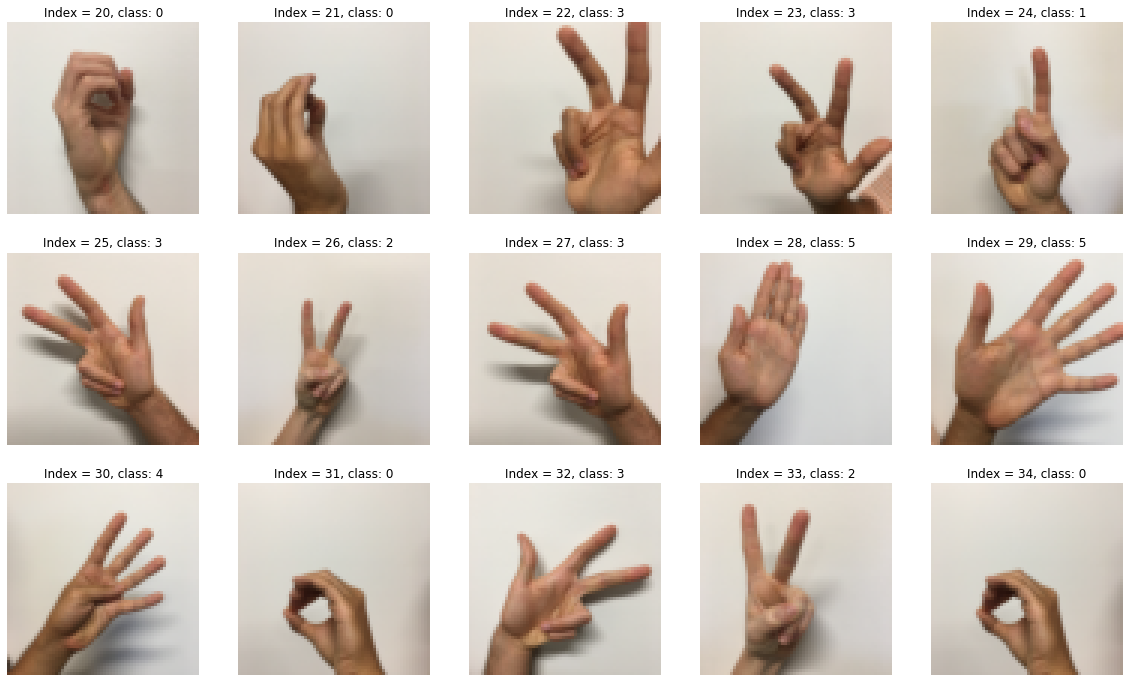

In [6]:
indices = [i for i in range(20, 35, 1)]
example(indices, train_x_orig, train_y_orig, classes)

## 4. Data Pre-Processing

We flatten the image dataset, then normalize it by dividing by 255. On top of that, we convert each label to a one-hot vector.

In [7]:
# convert Y to one-hot vectors

def convert_to_one_hot(Y, C):
    """
    Argument:
    Y: labels, with the dimension of (1, number of examples)
    C: number of classes
    
    Returns:
    Y_converted: one-hot representation of Y, with the dimension of (C, number of examples)
    """
    # numpy.eye(): Return a 2-D array with ones on the diagonal and zeros elsewhere.
    # note that the ith column is exactly the one-hot representation of the ith class 
    Y_converted = np.eye(C)[:, Y.reshape(-1)]
    
    return Y_converted

In [8]:
# pre-processing the features

# standardize, so the values are between 0 and 1.
train_x = train_x_orig / 255
test_x = test_x_orig / 255

# convert labels to one-hot vectors, and make the dimension (number of examples, number of classes)
train_y = convert_to_one_hot(train_y_orig, len(classes)).T
test_y = convert_to_one_hot(test_y_orig, len(classes)).T


print("dimension of train_x: " + str(train_x.shape))
print("dimension of test_x: " + str(test_x.shape))
print("dimension of train_y: " + str(train_y.shape))
print("dimension of test_y: " + str(test_y.shape))

dimension of train_x: (1080, 64, 64, 3)
dimension of test_x: (120, 64, 64, 3)
dimension of train_y: (1080, 6)
dimension of test_y: (120, 6)


## 5. Model Training

To train and test the model, there are four steps in Keras:
1. Create the model
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

In [12]:
# step 1: create the model

my_model = model(input_shape = (64, 64, 3))

In [13]:
# step 2: compile the model to configure the learning process

my_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
# step 3: train the model

my_model.fit(x = train_x, y = train_y, batch_size = 64, epochs = 25)

Epoch 1/25
1080/1080 [==============================] - 30s 27ms/step - loss: 2.0013 - acc: 0.4574
Epoch 2/25
1080/1080 [==============================] - 28s 26ms/step - loss: 0.5737 - acc: 0.7944
Epoch 3/25
1080/1080 [==============================] - 29s 27ms/step - loss: 0.2717 - acc: 0.9120
Epoch 4/25
1080/1080 [==============================] - 29s 27ms/step - loss: 0.1567 - acc: 0.9611
Epoch 5/25
1080/1080 [==============================] - 28s 26ms/step - loss: 0.1218 - acc: 0.9657
Epoch 6/25
1080/1080 [==============================] - 28s 26ms/step - loss: 0.1255 - acc: 0.9639
Epoch 7/25
1080/1080 [==============================] - 28s 26ms/step - loss: 0.0881 - acc: 0.9796
Epoch 8/25
1080/1080 [==============================] - 27s 25ms/step - loss: 0.0409 - acc: 0.9944
Epoch 9/25
1080/1080 [==============================] - 29s 26ms/step - loss: 0.0255 - acc: 0.9981
Epoch 10/25
1080/1080 [==============================] - 28s 26ms/step - loss: 0.0203 - acc: 1.0000
Epoch 11/

In [15]:
# step 4: evaluate/test the model

preds = my_model.evaluate(x = test_x, y =test_y)
print("Loss: " + str(preds[0]))
print("Accuracy: " + str(preds[1]))

120/120 [==============================] - 2s 16ms/step
Loss: 0.0907508817811807
Accuracy: 0.975


## 6. Model Schematics

### 6.1 Model Summary

model.summary(): prints the details of our model in a table with the sizes of its inputs/outputs

In [16]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 26, 64)        100416    
__________

### 6.2 Model Layout

keras.utils.plot_model(): plots our graph in a nice layout. We can even save it as ".png" using SVG() if we'd like to share it on social media.

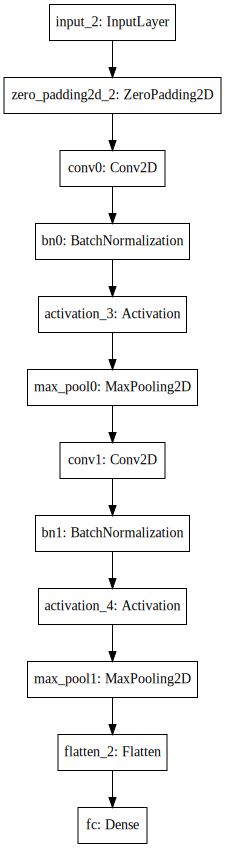

In [17]:
plot_model(my_model, to_file='images/MyModel.png', show_shapes = True)
SVG(model_to_dot(my_model).create(prog='dot', format='svg'))